# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material is an extract and slight rewrite by Alan Edelman of a wonderful lecture by Steven Johnson at MIT: 
https://github.com/mitmath/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7)# 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.8374568285394838
 0.2668170661102116
 0.5461702501885006
 0.12698132139180573
 0.28744027416019635
 0.21556521154423014
 0.5167222590088955
 0.32341759757930366
 0.25901833507531913
 0.811668282071529
 0.9851728762188939
 0.3535318796963085
 0.6340291512303315
 ⋮
 0.47792794111224124
 0.1364414808725053
 0.7064185950509211
 0.833339308150013
 0.06488006286117654
 0.5729413465894967
 0.39238471340419667
 0.659412845082096
 0.22850469709712584
 0.8722826903071215
 0.6919698399333077
 0.7354182292124429

In [2]:
sum(a) #

4.999507564252673e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [3]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [4]:
using Libdl

In [5]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):


open(`gcc  -fPIC -O3   -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
#open(`gcc  -fPIC -O3 -ffast-math  -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [6]:
c_sum(a)

4.999507564252658e6

In [7]:
c_sum(a) - sum(a) # Compare the c_sum with the julia built in sum

-1.4901161193847656e-8

In [8]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb  

true

In [9]:
≈  # alias for the `isapprox` function   

isapprox (generic function with 9 methods)

In [ ]:
?isapprox

We can now benchmark the C code directly from Julia:

In [11]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 534 samples with 1 evaluation.
 Range (min … max):  9.295 ms …  9.641 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.355 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.357 ms ± 44.491 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    █                                                         
  ▄███▄▇▆▆▅▇▇▆▇▆▆▇▄▄▆▇▇▄▆▇▇▅▆▆▇▆▇▅▅▅▄▅▄▃▅▃▂▃▄▃▂▂▃▃▃▂▂▁▁▁▂▁▁▂ ▄
  9.3 ms         Histogram: frequency by time        9.49 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [12]:
c_bench.times  # m=miliseconds = 10^(-3)  μ=microseconds = 10^(-6)  n = nanoseconds = 10^(-9)

534-element Vector{Float64}:
 9.365709e6
 9.343708e6
 9.301459e6
 9.372291e6
 9.300625e6
 9.358208e6
 9.3015e6
 9.342541e6
 9.303334e6
 9.353834e6
 9.299458e6
 9.298792e6
 9.42325e6
 ⋮
 9.362042e6
 9.432792e6
 9.413667e6
 9.325666e6
 9.391084e6
 9.395708e6
 9.397208e6
 9.411875e6
 9.429791e6
 9.310541e6
 9.333042e6
 9.313792e6

In [13]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec") 

C: Fastest time was 9.295083 msec


In [14]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 9.29508

In [15]:
using Plots
gr()

Plots.GRBackend()

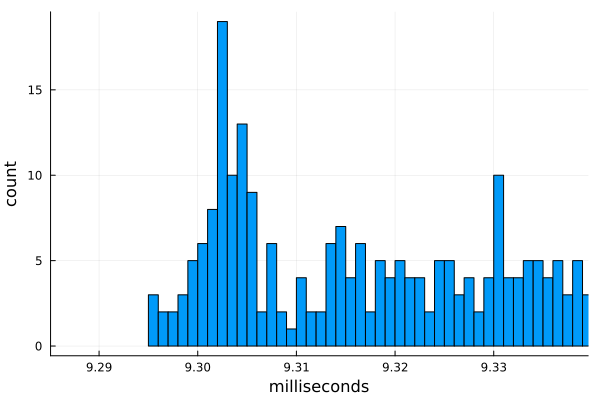

In [16]:
using Statistics

t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [17]:
#]add PyCall

In [18]:
using PyCall

In [19]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [20]:
pysum(a)

4.999507564252658e6

In [21]:
pysum(a) ≈ sum(a)

true

In [22]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 12 samples with 1 evaluation.
 Range (min … max):  416.273 ms … 425.517 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     421.056 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   421.121 ms ±   2.599 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁  ▁                         ██ ▁ ▁     ▁   ▁    ▁          ▁  
  █▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁█▁█▁▁▁▁▁█▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█ ▁
  416 ms           Histogram: frequency by time          426 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [23]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 2 entries:
  "C"               => 9.29508
  "Python built-in" => 416.273

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [24]:
# using Pkg

In [25]:
# Pkg.add("Conda")

In [26]:
using Conda 
#Conda.add("numpy")

In [27]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 2698 samples with 1 evaluation.
 Range (min … max):  1.813 ms …  2.584 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.827 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.843 ms ± 46.490 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▂                                                         
  ███▇▆▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▂▂▂▁▂▁▂▂▂ ▃
  1.81 ms        Histogram: frequency by time        2.03 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [28]:
numpy_sum(a) 

4.999507564252674e6

In [29]:
numpy_sum(a) ≈ sum(a)

true

In [30]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.29508
  "Python numpy"    => 1.81279
  "Python built-in" => 416.273

# 4. Python, hand-written

In [ ]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

In [ ]:
py_hand = @benchmark $sum_py($a)

In [ ]:
sum_py(a)

In [ ]:
sum_py(a) ≈ sum(a)

In [ ]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [ ]:
@which sum(a)

In [ ]:
j_bench = @benchmark sum($a)

In [ ]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

# 6. Julia (hand-written)

In [ ]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    #@inbounds @simd for a in A
    for a in A
        s += a
    end
    s
end

In [ ]:
j_bench_hand = @benchmark mysum($a)

In [ ]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

 # 7. Julia hand-written ++

In [ ]:
function myfastsum(A)   
    s = 0.0  # s = zero(eltype(A))
   @simd for a in A  # <-- don't check bounds, parallel on processor
        s += a
    end
    s
end

In [ ]:
j_bench_hand_pp = @benchmark myfastsum($a)

In [ ]:
d["Julia hand-written-pp"] = minimum(j_bench_hand_pp.times) / 1e6
d

# Summary

In [ ]:
for (key, value) in sort(collect(d))
    println(rpad(key, 20, "."), lpad(round(value, digits=1), 8, "."))
end

In [ ]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, digits=2), 10, "."))
end

In [ ]:
n=10000
a = [rand(1,3) for i=1:n]
b = [rand(3) for i=1:n]
dist(x,y) = norm(x-y)
@time dist.(a',b)